In [18]:
import pickle
import sys
import numpy as np
import pandas as pd
import artm
import seaborn as sns
print artm.version()

from os import path, mkdir
from datetime import datetime
sys.path.insert(0, '..\\modules\\helpers')
from plot_helper import PlotMaker
from config_helper import ConfigPaths
from print_helper import PrintHelper
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull
from scipy.optimize import minimize
from sklearn.metrics.pairwise import cosine_distances
from numpy.linalg import norm as euclidean_norm

%matplotlib inline

0.8.1


In [4]:
config = ConfigPaths('config.cfg')
plot_maker = PlotMaker()
printer = PrintHelper()

In [5]:
print config.models_file_name

Q:\\topic_modeling\\csi_science_collections.git\experiments\UCI_filtered_ngramm_trimmed_without_names\np_10_12_500_opt_dists_3\models.txt


In [11]:
models_file = open(config.models_file_name, 'a')

In [12]:
def create_model(current_dictionary, n_topics, n_doc_passes, seed_value, n_top_tokens, p_mass_threshold):    
    print '[{}] creating model'.format(datetime.now())
    model = artm.ARTM(num_topics=n_topics, dictionary=current_dictionary, cache_theta=True, seed=seed_value, 
                  class_ids={'ngramm': 1.0, 'author_id': 0.0, 'author': 0.0, 
                             'post_tag': 0.0, 'projects': 0.0, 'category': 0.0,
                             'following_users': 0.0})
    model.num_document_passes = n_doc_passes
    add_scores_to_model(model, n_top_tokens=n_top_tokens, p_mass_threshold=p_mass_threshold)
    return model


def add_scores_to_model(artm_model, n_top_tokens, p_mass_threshold):
    print '[{}] adding scores'.format(datetime.now())
    artm_model.scores.add(artm.PerplexityScore(name='perplexity_score',
                                      use_unigram_document_model=False,
                                      dictionary=dictionary))
    artm_model.scores.add(artm.SparsityPhiScore(name='sparsity_phi_score', class_id='ngramm'))
    artm_model.scores.add(artm.SparsityThetaScore(name='sparsity_theta_score'))
    artm_model.scores.add(artm.TopicKernelScore(name='topic_kernel_score', class_id='ngramm', 
                                                probability_mass_threshold=p_mass_threshold))
    artm_model.scores.add(artm.TopTokensScore(name='top_tokens_score', class_id='ngramm', num_tokens=n_top_tokens))
def fit_one_model(model, _n_iterations, _model_name=''): 
    print '[{}] fitting'.format(datetime.now())
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=_n_iterations)
    print '[{}] outputting'.format(datetime.now())
    printer.print_artm_model(model, _model_name, _n_iterations, output_file=models_file)
    model_pics_file_name =  path.join(config.experiment_path, _model_name)
    plot_maker.make_tm_plots(model, model_pics_file_name)
    model_output_file_name = path.join(config.experiment_path, _model_name + '.txt')
    printer.print_scores(model, _model_name, _n_iterations, model_output_file_name)
    printer.print_top_tokens(model, model_output_file_name)
    return model
def save_pickle_file(dists, filename):
    pickle_filename = path.join(config.experiment_path, filename)
    pickle_file = open(pickle_filename, 'wb')
    pickle.dump(dists, pickle_file)
    pickle_file.close()
def load_pickle_file(filename):
    pickle_filename = path.join(config.experiment_path, filename)
    pickle_file = open(pickle_filename, 'rb')
    p_file = pickle.load(pickle_file)
    pickle_file.close()
    return p_file

In [13]:
batch_vectorizer = artm.BatchVectorizer(data_path=config.output_batches_path,
                                        data_format='batches')
dictionary = artm.Dictionary()
dictionary.load(dictionary_path=config.dictionary_path + '.dict')

In [14]:
tmp_model = create_model(current_dictionary=dictionary, n_topics=500, n_doc_passes=5, seed_value=100,
                            n_top_tokens=15, p_mass_threshold=0.25)
tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['ngramm']))
tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['ngramm']))
tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 100
tmp_model.regularizers['ss_theta_regularizer'].tau = -0.1
tmp_model.regularizers['ss_phi_regularizer'].tau = -0.05
tmp_model = fit_one_model(tmp_model, _n_iterations=20, _model_name='model2')
model2 = tmp_model; tmp_model = None

[2016-12-11 10:18:02.196000] creating model
[2016-12-11 10:18:04.703000] adding scores
[2016-12-11 10:18:04.740000] fitting
[2016-12-11 10:21:26.607000] outputting
name = model2, n_topics = 500, n_doc_passes = 5, seed_value = 100, n_iterations = 20, n_top_tokens = 15, p_threshold = 0.25
ss_theta_regularizer, tau = -0.1
decorrelator_phi_regularizer, tau = 100
ss_phi_regularizer, tau = -0.05



In [33]:
model2.score_tracker['sparsity_theta_score'].last_value

0.8965722576900754

In [8]:
def euc_dist(p, q):
    return euclidean_norm(p - q)
def euc_dist_grad(b, A, x):
    x = x.reshape(-1, 1)
    b = b.reshape(-1, 1)
    norm = euc_dist(A.dot(x), b)
    res = A.T.dot(A.dot(x) - b)
    if norm != 0:
        res = res / norm
    return res
def cos_dist(p, q):
    p = p.reshape(-1, 1)
    q = q.reshape(-1, 1)
    return cosine_distances(p, q)[0][0]
def cos_dist_grad(b, A, x):
    x = x.reshape(-1, 1)
    b = b.reshape(-1, 1)
    y = A.dot(x)
    u = b.T.dot(y) # number
    deriv_u = A.T.dot(b) * x
    v = euclidean_norm(y) * euclidean_norm(b)
    nom = deriv_u * v - A.T.dot(A).dot(x) * u[0][0] * euclidean_norm(b) / euclidean_norm(y)
    denom = v * v
    if denom != 0:
        res = nom / denom
    else:
        res = nom
    return -res
def hellinger_dist(p, q):
    return np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2)) / np.sqrt(2) 
def hellinger_dist_grad(b, A, x):
    y = A.dot(x)
    nom = np.divide(np.sqrt(y) - np.sqrt(b), np.sqrt(y)).dot(A)
    denom = 2 * hellinger_dist(y, b) * np.sqrt(2)
    res = nom / denom 
    return res
def hellinger_dist_grad_nan(b, A, x):
    y = A.dot(x)
    tmp = np.divide(np.sqrt(y) - np.sqrt(b), np.sqrt(y))
    tmp[np.isnan(tmp)] = 0
    nom = tmp.dot(A)
    denom = 2 * hellinger_dist(y, b) * np.sqrt(2)
    res = nom / denom 
    return res
def hellinger_dist_grad_eps(b, A, x):
    y = A.dot(x)
    y[y == 0] = 1e-3
    tmp = np.divide(np.sqrt(y) - np.sqrt(b), np.sqrt(y))
    nom = tmp.dot(A)
    denom = 2 * hellinger_dist(y, b) * np.sqrt(2)
    res = nom / denom 
    return res

In [9]:
def print_optimal_solution_eps(_sol):
    _eps = 1e-2
    x = _sol.x
    c = _sol.column_names
    x_mask = x >_eps
    x_cut = x[x_mask]
    c_cut = c[x_mask]
    combination = ', '.join(['{} : {}'.format(c_cut[ind], x_cut[ind]) for ind in range(len(x_cut))])
    print 'fun = {}, optimized = {}'.format(_sol.fun, _sol.success)
    print '{}: {}'.format(_sol.optimized_column, combination)
def print_optimal_solution(_sol, _distances=None, _saved_top_tokens=None):
    x = _sol.x
    c = _sol.column_names
    sorted_x = sorted(zip(x, c), reverse=True)[0 : NUM_INDICES]
    if _distances is not None:
        combination = ', '.join(['{0} : {1:0.2f} [{2:0.2f}]'.format(item[1], item[0], _distances[_sol.optimized_column][item[1]]) for item in sorted_x])
        combination += '\n' + distances_to_str_row(_distances, _sol.optimized_column, _n_topics=NUM_INDICES)
    else:
        combination = ', '.join(['{0} : {1:0.2f}'.format(item[1], item[0]) for item in sorted_x])
    print '============================'
    print 'fun = {}, optimized = {}'.format(_sol.fun, _sol.success)
    print '{} | {}'.format(_sol.optimized_column, combination)
    if _saved_top_tokens is not None:
        topics_str = optimal_solution_topics_to_str(_saved_top_tokens, _sol.optimized_column, sorted_x)
        print topics_str
    print '============================'
def unicode_list_to_str(_name, _list):
    return _name + ': ' + ' '.join(_list)
def optimal_solution_topics_to_str(_saved_top_tokens, topic_name, sorted_x):
    topics = [item[1] for item in sorted_x]
    topics.insert(0, topic_name)
    str = ""
    for topic_name in topics:
        str += unicode_list_to_str(topic_name, _saved_top_tokens[topic_name]) + '\n'
    return str
def calculate_distances(dist_fun, _phi, _phi_other):
    print '[{}] take_distances between {} columns and {} columns'.format(datetime.now(), len(_phi.columns), len(_phi_other.columns))
    distances = pd.DataFrame(0, index = _phi.columns, columns=_phi_other.columns)
    for idx, col in enumerate(_phi.columns):
        print '[{}] column num {} of {}'.format(datetime.now(), idx, len(_phi.columns))
        for idx_other, col_other in enumerate(_phi_other.columns):
            distance = dist_fun(_phi[col], _phi_other[col_other])
            distances.iloc[idx, idx_other] = distance
    return distances
def distances_to_str_row(distances, topic, _n_topics):
    values = distances[topic].sort_values().head(_n_topics)
    value = ', '.join(['{0} : [{1:0.2f}]'.format(values.index[ind], values[ind]) for ind in range(len(values))])
    str = 'closest by distance to {} | {}\n'.format(topic, value)
    return str
def calculate_distances_one_col(dist, phi, column): 
    distances = pd.DataFrame(0, index = range(1), columns=phi.columns)
    for idx, col in enumerate(phi.columns):
        distance = dist(column, phi[col])
        distances.iloc[0, idx] = distance
    return distances
def get_optimization_result(dist_fn, jac_dist_fn, phi, distances):
    opt_results = {}
    for col_idx, col in enumerate(phi.columns):
        print '[{}] get_optimization_result for column {}'.format(datetime.now(), col_idx)
        opt_results[col] = solve_optimization_problem(dist_fn, jac_dist_fn, col_idx, phi, distances)
    return opt_results
def solve_optimization_problem(dist_fn, jac_dist_fn, col_idx, phi, distances, verbose=False):
    max_iter = 50
    col_name = phi.columns[col_idx]
    col = phi[col_name]
    # get n closest topics
    closest_indices = distances[col_name].sort_values().head(N_CLOSEST_TOPICS).index.values
    phi_closest = phi[closest_indices]
    # delete zero rows from matrix
    phi_closest_nz = phi_closest[(phi_closest.T != 0).any()]
    col_nz = phi_closest_nz[col_name]
    # delete col from phi
    phi_cut_nz = phi_closest_nz.drop(col_name, axis=1)
    
    # opt solver
    n_columns = phi_cut_nz.shape[1] 
    bnds = [(0, 1)] * n_columns
    constraints = cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1, 'jac': lambda x: [1] * n_columns})
    opt_fun = lambda x: dist_fn(col_nz, phi_cut_nz.dot(x))
    jac_fun = lambda x: jac_dist_fn(col_nz, phi_cut_nz, x)
    
    is_optimized = False
    it = 0
    while (not is_optimized) and it != 4:
        it += 1
        init_x = np.random.uniform(0, 1, (1, n_columns))
        init_x /= np.sum(init_x)
        if jac_dist_fn is not None:
            res = minimize(opt_fun, jac=jac_fun, x0=init_x, method='SLSQP', bounds=bnds, constraints=cons, options={'maxiter': max_iter, 'disp': verbose})
        else:
            res = minimize(opt_fun, x0=init_x, method='SLSQP', bounds=bnds, constraints=cons, options={'maxiter': max_iter, 'disp': verbose})
        is_optimized = res.success
    res['column_names'] = phi_cut_nz.columns
    res['optimized_column'] = col_name
    return res

In [10]:
N_CLOSEST_TOPICS = 25
NUM_INDICES = 10

In [11]:

phi1 = model1.get_phi()
phi1 = phi1[(phi1.T != 0).any()]
saved_top_tokens1 = model1.score_tracker['top_tokens_score'].last_tokens

phi = phi1
saved_top_tokens = saved_top_tokens1

In [12]:
distances = calculate_distances(hellinger_dist, phi, phi)

[2016-12-11 01:58:27.310000] take_distances between 500 columns and 500 columns
[2016-12-11 01:58:27.313000] column num 0 of 500
[2016-12-11 01:58:29.925000] column num 1 of 500
[2016-12-11 01:58:30.955000] column num 2 of 500
[2016-12-11 01:58:32.037000] column num 3 of 500
[2016-12-11 01:58:33.074000] column num 4 of 500
[2016-12-11 01:58:34.086000] column num 5 of 500
[2016-12-11 01:58:35.104000] column num 6 of 500
[2016-12-11 01:58:36.510000] column num 7 of 500
[2016-12-11 01:58:37.737000] column num 8 of 500
[2016-12-11 01:58:38.826000] column num 9 of 500
[2016-12-11 01:58:39.851000] column num 10 of 500
[2016-12-11 01:58:40.965000] column num 11 of 500
[2016-12-11 01:58:42.222000] column num 12 of 500
[2016-12-11 01:58:43.376000] column num 13 of 500
[2016-12-11 01:58:44.773000] column num 14 of 500
[2016-12-11 01:58:46.124000] column num 15 of 500
[2016-12-11 01:58:47.141000] column num 16 of 500
[2016-12-11 01:58:48.196000] column num 17 of 500
[2016-12-11 01:58:49.214000] c

In [13]:
ds1 = get_optimization_result(hellinger_dist, None, phi, distances)
ds = ds1
save_pickle_file(ds, 'dists_h_none.p')

[2016-12-11 02:06:53.759000] get_optimization_result for column 0
[2016-12-11 02:06:54.089000] get_optimization_result for column 1
[2016-12-11 02:06:54.530000] get_optimization_result for column 2
[2016-12-11 02:06:54.741000] get_optimization_result for column 3
[2016-12-11 02:06:55.306000] get_optimization_result for column 4
[2016-12-11 02:06:55.735000] get_optimization_result for column 5
[2016-12-11 02:06:56.085000] get_optimization_result for column 6
[2016-12-11 02:06:56.485000] get_optimization_result for column 7
[2016-12-11 02:06:57.236000] get_optimization_result for column 8
[2016-12-11 02:06:57.695000] get_optimization_result for column 9
[2016-12-11 02:06:58.002000] get_optimization_result for column 10
[2016-12-11 02:06:58.376000] get_optimization_result for column 11
[2016-12-11 02:06:58.855000] get_optimization_result for column 12
[2016-12-11 02:06:59.260000] get_optimization_result for column 13
[2016-12-11 02:06:59.588000] get_optimization_result for column 14
[2016

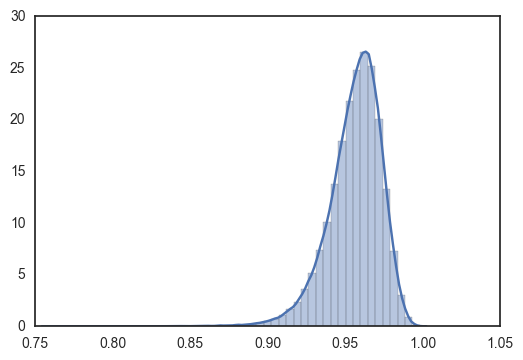

In [18]:
# построим распределение полученных distances
vals = distances.values.flatten()
sns.distplot(vals[vals != 0])

In [ ]:
# построим распределение полученных opt_fun 

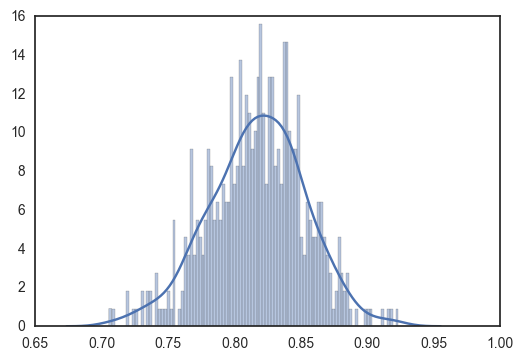

In [17]:
fs = [ds[col].fun for col in phi.columns]
sns.distplot(fs, bins=100)

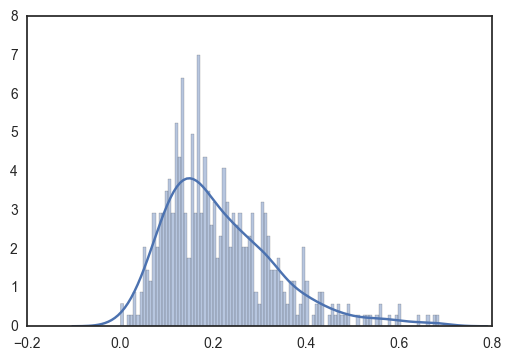

In [19]:
xs = [ds[col].x[0] for col in phi.columns]
sns.distplot(xs, bins=100)

In [20]:
def get_topics_to_remove_by_closest_dist(small_dist_opts, distances):
    n_closest = 10
    sorted_by_fun = sorted(small_dist_opts.values(), key = lambda opt: opt.x[0])
    topics_to_remove = []
    for opt_res in sorted_by_fun:
        topic_name = opt_res.optimized_column
        # check not close to current topics to remove
        is_closest = lambda topic, other_topic: np.any(distances[topic].sort_values().head(n_closest).index.values == other_topic)
        dists_to_topics_to_remove = [not is_closest(topic_name, t) for t in topics_to_remove]
        is_far = np.all(np.array(dists_to_topics_to_remove))
        if is_far:
            topics_to_remove.append(topic_name)
    return topics_to_remove
def remove_topics_from_phi(phi, topics_to_remove):
    return phi.drop(topics_to_remove, axis=1)
def remove_topics_from_distances(distances, topics_to_remove):
    distances_convex_hull = distances.drop(topics_to_remove, axis=1)
    distances_convex_hull = distances_convex_hull.drop(topics_to_remove, axis=0)
    return distances_convex_hull

In [21]:
def find_topics_to_remove(_opt_res, _phi_convex_hull, _distances_convex_hull, x_th):     
    possible_duplicates_opts = {col: _opt_res[col] for col in _phi_convex_hull.columns if _opt_res[col].x[0] > x_th}
    print len(possible_duplicates_opts)
    topics_to_remove_by_closest_dist = get_topics_to_remove_by_closest_dist(possible_duplicates_opts, _distances_convex_hull)
    print 'topics to remove = ', len(topics_to_remove_by_closest_dist)
    print '\n'.join([unicode_list_to_str(topic_name, saved_top_tokens[topic_name][0:11]) for topic_name in topics_to_remove_by_closest_dist])
    return topics_to_remove_by_closest_dist

In [22]:
phi_convex_hull, distances_convex_hull, opt_res_convex_hull = phi, distances, ds

In [ ]:
# iteration = 1

In [23]:
x_th = 0.4
topics_to_remove_by_closest_dist = find_topics_to_remove(opt_res_convex_hull, phi_convex_hull, distances_convex_hull, x_th)

37
topics to remove =  25
topic_254: цвета цвет алмаз твёрдость структура пора фотоаппарат модификация взрыв ряд палочка
topic_118: слово словарь значение русский_язык цитата значение_слово вопрос пример язык предмет место
topic_327: нейрон мозг нервный_клетка связь гиппокамп нервный_система аксон помощь процесс работа исследование
topic_383: история историк воспоминание исторический_память связь место историография пора великое вопрос профессиональный_историк
topic_466: игра игрок теория_игра ход шахматы результат гибридизация позиция дерево сторона друг
topic_278: белка белок клетка приона цитоплазма домен шаперон агрегат состояние фибрилла дрожжи
topic_255: ребёнок родитель взрослый возраст девочка случай ситуация развитие друг возможность навык
topic_238: большой_адронный_коллайдер высокий_энергия поль электрон стандартный_модель энергия квант единый_теория область интенсивность элементарный_частица
topic_21: социология общество социолог социальный_наука дисциплина сторона дюркгейм

In [24]:
phi_convex_hull = remove_topics_from_phi(phi_convex_hull, topics_to_remove_by_closest_dist)
distances_convex_hull = remove_topics_from_distances(distances_convex_hull, topics_to_remove_by_closest_dist)

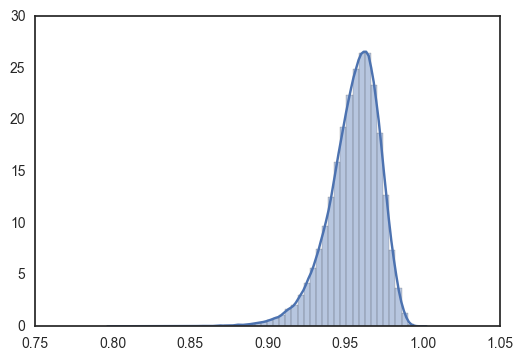

In [26]:
vals = distances_convex_hull.values.flatten()
sns.distplot(vals[vals != 0])

In [ ]:
# iteration = 2

[2016-12-11 02:13:01.311000] get_optimization_result for column 0
[2016-12-11 02:13:01.637000] get_optimization_result for column 1
[2016-12-11 02:13:01.698000] get_optimization_result for column 2
[2016-12-11 02:13:01.945000] get_optimization_result for column 3
[2016-12-11 02:13:02.601000] get_optimization_result for column 4
[2016-12-11 02:13:02.927000] get_optimization_result for column 5
[2016-12-11 02:13:03.239000] get_optimization_result for column 6
[2016-12-11 02:13:03.647000] get_optimization_result for column 7
[2016-12-11 02:13:04.351000] get_optimization_result for column 8
[2016-12-11 02:13:04.622000] get_optimization_result for column 9
[2016-12-11 02:13:05.404000] get_optimization_result for column 10
[2016-12-11 02:13:06.059000] get_optimization_result for column 11
[2016-12-11 02:13:06.566000] get_optimization_result for column 12
[2016-12-11 02:13:07.228000] get_optimization_result for column 13
[2016-12-11 02:13:07.836000] get_optimization_result for column 14
[2016

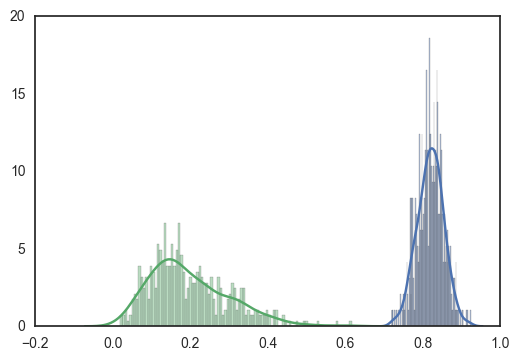

In [25]:
ds2 = get_optimization_result(hellinger_dist, None, phi_convex_hull, distances_convex_hull)
opt_res_convex_hull = ds2
save_pickle_file(opt_res_convex_hull, 'dists_h_none2.p')
fs = [opt_res_convex_hull[col].fun for col in phi_convex_hull.columns]
sns.distplot(fs, bins=100)
xs = [opt_res_convex_hull[col].x[0] for col in phi_convex_hull.columns]
sns.distplot(xs, bins=100)

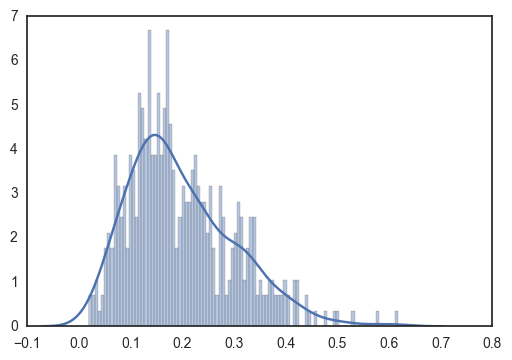

In [27]:
xs = [opt_res_convex_hull[col].x[0] for col in phi_convex_hull.columns]
sns.distplot(xs, bins=100)

In [28]:
x_th = 0.4
topics_to_remove_by_closest_dist = find_topics_to_remove(opt_res_convex_hull, phi_convex_hull, distances_convex_hull, x_th)
phi_convex_hull = remove_topics_from_phi(phi_convex_hull, topics_to_remove_by_closest_dist)
distances_convex_hull = remove_topics_from_distances(distances_convex_hull, topics_to_remove_by_closest_dist)

19
topics to remove =  16
topic_226: массовый_культура зомби сериал критический_теория тема современный_культура проблема культуролог живой_мертвец образ популярность
topic_455: свет фотон поляризация электрон лазер состояние источник образ случай сторона способ
topic_350: книга читатель автор взгляд литература серия идея автор_книга жизнь страница издание
topic_39: днк молекула_днк генетический_информация крик уотсон двойной_спираль последовательность структура_днк форма последовательность_днк цепочка
topic_221: клетка мышка нервный_система нервный_клетка кожа клинический_испытание изменение часть моторный_нейрон друг синапс
topic_25: предложение парадигма предмет контекст заблуждение языковой_картина эксперимент жалость понимание место вид
topic_433: проблема уравнение решение объём надёжность помощь америка американец работа часть вычислительный_техника
topic_74: гласный русский_язык говор слово произношение литературный_язык ударение звук австралийский_абориген мягкий_согласный дре

In [ ]:
# iteration = 3

[2016-12-11 02:17:49.388000] get_optimization_result for column 0
[2016-12-11 02:17:49.707000] get_optimization_result for column 1
[2016-12-11 02:17:50.039000] get_optimization_result for column 2
[2016-12-11 02:17:50.269000] get_optimization_result for column 3
[2016-12-11 02:17:50.529000] get_optimization_result for column 4
[2016-12-11 02:17:50.944000] get_optimization_result for column 5
[2016-12-11 02:17:51.246000] get_optimization_result for column 6
[2016-12-11 02:17:51.687000] get_optimization_result for column 7
[2016-12-11 02:17:52.039000] get_optimization_result for column 8
[2016-12-11 02:17:52.507000] get_optimization_result for column 9
[2016-12-11 02:17:53.075000] get_optimization_result for column 10
[2016-12-11 02:17:53.626000] get_optimization_result for column 11
[2016-12-11 02:17:53.958000] get_optimization_result for column 12
[2016-12-11 02:17:54.271000] get_optimization_result for column 13
[2016-12-11 02:17:54.547000] get_optimization_result for column 14
[2016

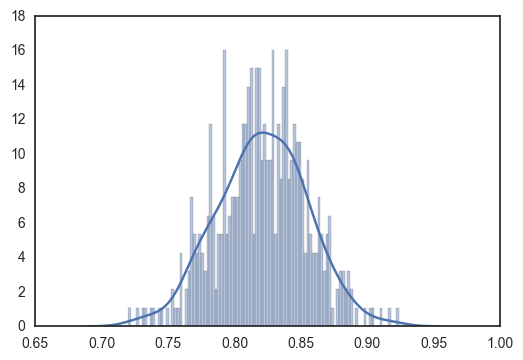

In [30]:
ds3 = get_optimization_result(hellinger_dist, None, phi_convex_hull, distances_convex_hull)
opt_res_convex_hull = ds3
save_pickle_file(opt_res_convex_hull, 'dists_h_none3.p')
fs = [opt_res_convex_hull[col].fun for col in phi_convex_hull.columns]
sns.distplot(fs, bins=100)

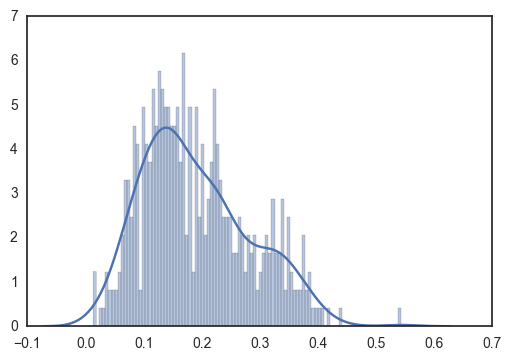

In [31]:
xs = [opt_res_convex_hull[col].x[0] for col in phi_convex_hull.columns]
sns.distplot(xs, bins=100)

In [32]:
x_th = 0.4
topics_to_remove_by_closest_dist = find_topics_to_remove(opt_res_convex_hull, phi_convex_hull, distances_convex_hull, x_th)
phi_convex_hull = remove_topics_from_phi(phi_convex_hull, topics_to_remove_by_closest_dist)
distances_convex_hull = remove_topics_from_distances(distances_convex_hull, topics_to_remove_by_closest_dist)

5
topics to remove =  4
topic_36: компьютер задача алгоритм процессор область вычисление машина ошибка программный_обеспечение суперкомпьютер секвенатор
topic_133: организм фермент клетка белка сторона многоклеточный_организм клеточный_биология сперматозоид жизнь геном субстрат
topic_108: мозг миллион шимпанзе человеческий_мозг друг головной_мозг жир префронтальный_кора макака мышца структура_мозг
topic_124: язык лингвист английский_язык разный_язык название лингвистика носитель вопрос слово факт простой


In [ ]:
# iteration = 4 

[2016-12-11 02:21:45.805000] get_optimization_result for column 0
[2016-12-11 02:21:46.130000] get_optimization_result for column 1
[2016-12-11 02:21:46.412000] get_optimization_result for column 2
[2016-12-11 02:21:46.568000] get_optimization_result for column 3
[2016-12-11 02:21:47.006000] get_optimization_result for column 4
[2016-12-11 02:21:47.367000] get_optimization_result for column 5
[2016-12-11 02:21:47.664000] get_optimization_result for column 6
[2016-12-11 02:21:48.106000] get_optimization_result for column 7
[2016-12-11 02:21:48.514000] get_optimization_result for column 8
[2016-12-11 02:21:48.853000] get_optimization_result for column 9
[2016-12-11 02:21:49.354000] get_optimization_result for column 10
[2016-12-11 02:21:49.958000] get_optimization_result for column 11
[2016-12-11 02:21:50.787000] get_optimization_result for column 12
[2016-12-11 02:21:51.098000] get_optimization_result for column 13
[2016-12-11 02:21:51.418000] get_optimization_result for column 14
[2016

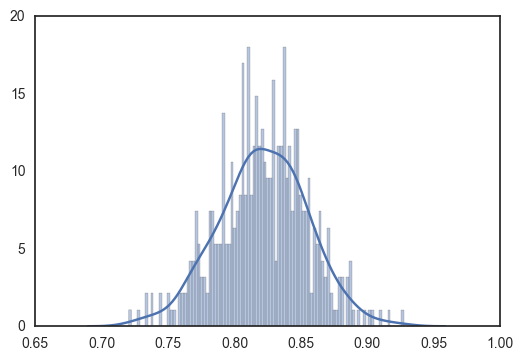

In [34]:
ds4 = get_optimization_result(hellinger_dist, None, phi_convex_hull, distances_convex_hull)
opt_res_convex_hull = ds4
save_pickle_file(opt_res_convex_hull, 'dists_h_none4.p')
fs = [opt_res_convex_hull[col].fun for col in phi_convex_hull.columns]
sns.distplot(fs, bins=100)

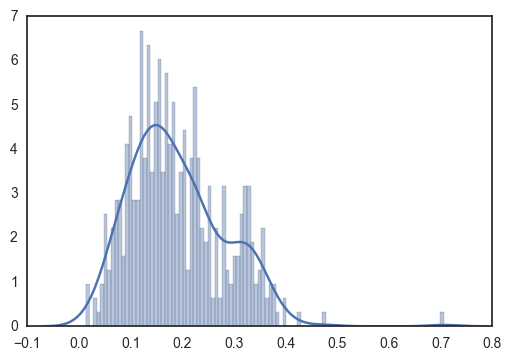

In [35]:
xs = [opt_res_convex_hull[col].x[0] for col in phi_convex_hull.columns]
sns.distplot(xs, bins=100)

In [36]:
x_th = 0.4
topics_to_remove_by_closest_dist = find_topics_to_remove(opt_res_convex_hull, phi_convex_hull, distances_convex_hull, x_th)

3
topics to remove =  3
topic_164: программа программист компилятор программирование понятие создание язык_программирование задача проектирование процесс компонент
topic_459: перевод словосочетание фразеологизм немецкий_язык контекст сфера голова частность идиом немецк эквивалент
topic_95: клетка ткань работа токсин живой_система химический_вещество открытие тип_клетка концентрация функционирование лимфоцит


In [37]:
for topic_name in topics_to_remove_by_closest_dist:
    print_optimal_solution(opt_res_convex_hull[topic_name], _distances=distances_convex_hull, _saved_top_tokens=saved_top_tokens)

fun = 0.810694376506, optimized = True
topic_164 | topic_166 : 0.42 [0.86], topic_241 : 0.11 [0.90], topic_161 : 0.09 [0.90], topic_170 : 0.09 [0.92], topic_258 : 0.09 [0.91], topic_416 : 0.05 [0.91], topic_277 : 0.05 [0.90], topic_418 : 0.02 [0.91], topic_188 : 0.02 [0.91], topic_68 : 0.02 [0.91]
closest by distance to topic_164 | topic_164 : [0.00], topic_166 : [0.86], topic_241 : [0.90], topic_161 : [0.90], topic_277 : [0.90], topic_188 : [0.91], topic_418 : [0.91], topic_68 : [0.91], topic_258 : [0.91], topic_271 : [0.91]

topic_164: программа программист компилятор программирование понятие создание язык_программирование задача проектирование процесс компонент сторона сфера оперативный_память работа
topic_166: код процесс_эволюция копирование искусственный_жизнь вид компьютер организм жизнь счёт вопрос оперативный_память паразит существо хозяин эволюционный_развитие
topic_241: задача мышление психолог решение инсайт проблема решение_задача этап психология исследование процесс групп

In [38]:
phi_convex_hull = remove_topics_from_phi(phi_convex_hull, topics_to_remove_by_closest_dist)
distances_convex_hull = remove_topics_from_distances(distances_convex_hull, topics_to_remove_by_closest_dist)

[2016-12-11 02:26:24.879000] get_optimization_result for column 0
[2016-12-11 02:26:25.235000] get_optimization_result for column 1
[2016-12-11 02:26:25.491000] get_optimization_result for column 2
[2016-12-11 02:26:25.739000] get_optimization_result for column 3
[2016-12-11 02:26:25.916000] get_optimization_result for column 4
[2016-12-11 02:26:26.111000] get_optimization_result for column 5
[2016-12-11 02:26:26.279000] get_optimization_result for column 6
[2016-12-11 02:26:26.710000] get_optimization_result for column 7
[2016-12-11 02:26:26.882000] get_optimization_result for column 8
[2016-12-11 02:26:27.259000] get_optimization_result for column 9
[2016-12-11 02:26:27.406000] get_optimization_result for column 10
[2016-12-11 02:26:27.950000] get_optimization_result for column 11
[2016-12-11 02:26:28.416000] get_optimization_result for column 12
[2016-12-11 02:26:28.876000] get_optimization_result for column 13
[2016-12-11 02:26:29.279000] get_optimization_result for column 14
[2016

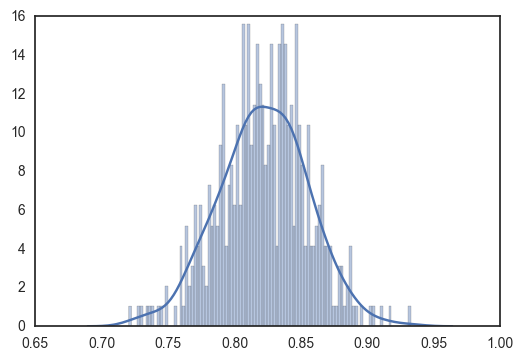

In [39]:
ds5 = get_optimization_result(hellinger_dist, None, phi_convex_hull, distances_convex_hull)
opt_res_convex_hull = ds5
save_pickle_file(opt_res_convex_hull, 'dists_h_none5.p')
fs = [opt_res_convex_hull[col].fun for col in phi_convex_hull.columns]
sns.distplot(fs, bins=100)

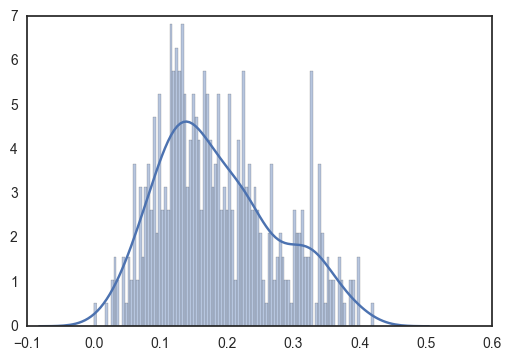

In [40]:
xs = [opt_res_convex_hull[col].x[0] for col in phi_convex_hull.columns]
sns.distplot(xs, bins=100)

In [41]:
x_th = 0.4
topics_to_remove_by_closest_dist = find_topics_to_remove(opt_res_convex_hull, phi_convex_hull, distances_convex_hull, x_th)
phi_convex_hull = remove_topics_from_phi(phi_convex_hull, topics_to_remove_by_closest_dist)
distances_convex_hull = remove_topics_from_distances(distances_convex_hull, topics_to_remove_by_closest_dist)

2
topics to remove =  2
topic_136: масса земля радиус гравитация сила кузнецов градиент поверхность_земля ближний электрический_заряд лоуренс
topic_55: сеть технология интернет протокол компания сервис доступ стандарт дом рынок специалист


In [ ]:
#iteration 6

[2016-12-11 02:30:01.448000] get_optimization_result for column 0
[2016-12-11 02:30:01.813000] get_optimization_result for column 1
[2016-12-11 02:30:02.189000] get_optimization_result for column 2
[2016-12-11 02:30:02.497000] get_optimization_result for column 3
[2016-12-11 02:30:02.795000] get_optimization_result for column 4
[2016-12-11 02:30:03.224000] get_optimization_result for column 5
[2016-12-11 02:30:03.538000] get_optimization_result for column 6
[2016-12-11 02:30:04.146000] get_optimization_result for column 7
[2016-12-11 02:30:04.419000] get_optimization_result for column 8
[2016-12-11 02:30:04.839000] get_optimization_result for column 9
[2016-12-11 02:30:05.109000] get_optimization_result for column 10
[2016-12-11 02:30:05.429000] get_optimization_result for column 11
[2016-12-11 02:30:05.941000] get_optimization_result for column 12
[2016-12-11 02:30:06.022000] get_optimization_result for column 13
[2016-12-11 02:30:06.284000] get_optimization_result for column 14
[2016

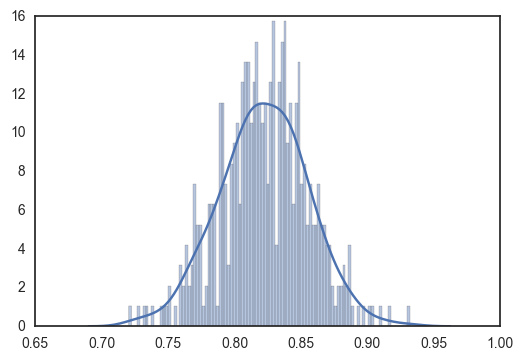

In [42]:
ds6 = get_optimization_result(hellinger_dist, None, phi_convex_hull, distances_convex_hull)
opt_res_convex_hull = ds6
save_pickle_file(opt_res_convex_hull, 'dists_h_none6.p')
fs = [opt_res_convex_hull[col].fun for col in phi_convex_hull.columns]
sns.distplot(fs, bins=100)

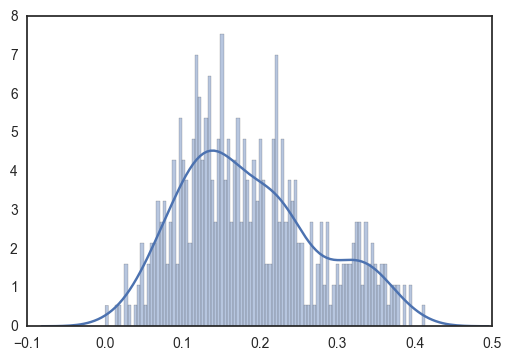

In [43]:
xs = [opt_res_convex_hull[col].x[0] for col in phi_convex_hull.columns]
sns.distplot(xs, bins=100)

In [44]:
x_th = 0.4
topics_to_remove_by_closest_dist = find_topics_to_remove(opt_res_convex_hull, phi_convex_hull, distances_convex_hull, x_th)
phi_convex_hull = remove_topics_from_phi(phi_convex_hull, topics_to_remove_by_closest_dist)
distances_convex_hull = remove_topics_from_distances(distances_convex_hull, topics_to_remove_by_closest_dist)

1
topics to remove =  1
topic_18: экономика экономист рынок экономический_теория экономический_наука экономический_рост издержка услуга спрос анализ цена


In [ ]:
#iteration 7

In [36]:
tops = phi_convex_hull.columns[0:5]
p_c = phi_convex_hull[tops]

In [52]:
w = phi_convex_hull.index[0:5]

In [66]:
distances_convex_hull[tops].T[tops].T

,topic_0,topic_1,topic_2,topic_4,topic_5
topic_0,0.000000,0.961217,0.968233,0.978367,0.966388
topic_1,0.961217,0.000000,0.955303,0.939722,0.935545
topic_2,0.968233,0.955303,0.000000,0.961130,0.954385
topic_4,0.978367,0.939722,0.961130,0.000000,0.969508
topic_5,0.966388,0.935545,0.954385,0.969508,0.000000


[2016-12-11 02:33:43.991000] get_optimization_result for column 0
[2016-12-11 02:33:44.339000] get_optimization_result for column 1
[2016-12-11 02:33:44.694000] get_optimization_result for column 2
[2016-12-11 02:33:44.944000] get_optimization_result for column 3
[2016-12-11 02:33:45.205000] get_optimization_result for column 4
[2016-12-11 02:33:45.614000] get_optimization_result for column 5
[2016-12-11 02:33:45.935000] get_optimization_result for column 6
[2016-12-11 02:33:46.395000] get_optimization_result for column 7
[2016-12-11 02:33:46.737000] get_optimization_result for column 8
[2016-12-11 02:33:46.991000] get_optimization_result for column 9
[2016-12-11 02:33:47.667000] get_optimization_result for column 10
[2016-12-11 02:33:48.185000] get_optimization_result for column 11
[2016-12-11 02:33:49.141000] get_optimization_result for column 12
[2016-12-11 02:33:49.497000] get_optimization_result for column 13
[2016-12-11 02:33:49.846000] get_optimization_result for column 14
[2016

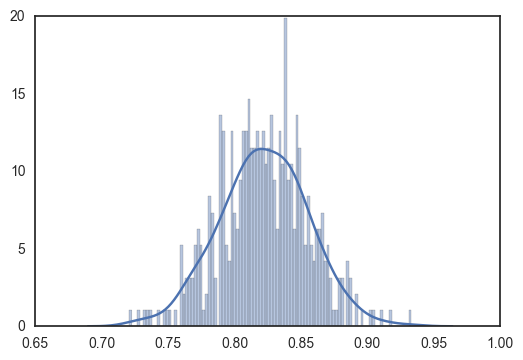

In [45]:
ds7 = get_optimization_result(hellinger_dist, None, phi_convex_hull, distances_convex_hull)
opt_res_convex_hull = ds7
save_pickle_file(opt_res_convex_hull, 'dists_h_none7.p')
fs = [opt_res_convex_hull[col].fun for col in phi_convex_hull.columns]
sns.distplot(fs, bins=100)

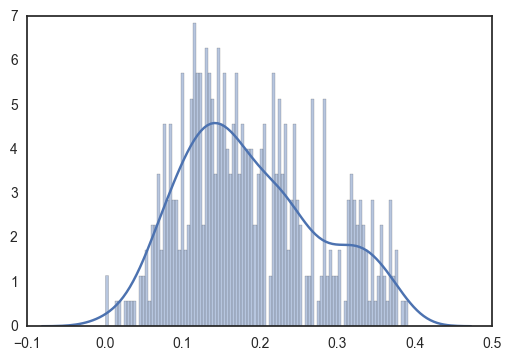

In [46]:
xs = [opt_res_convex_hull[col].x[0] for col in phi_convex_hull.columns]
sns.distplot(xs, bins=100)

In [ ]:
x_th = 0.4
topics_to_remove_by_closest_dist = find_topics_to_remove(opt_res_convex_hull, phi_convex_hull, distances_convex_hull, x_th)
phi_convex_hull = remove_topics_from_phi(phi_convex_hull, topics_to_remove_by_closest_dist)
distances_convex_hull = remove_topics_from_distances(distances_convex_hull, topics_to_remove_by_closest_dist)

In [ ]:
save_pickle_file(phi_convex_hull, 'phi_convex_hull_t2.p')
save_pickle_file(model1.get_theta(), 'theta_t2.p')
save_pickle_file(saved_top_tokens, 'saved_top_tokens_t2.p')

In [ ]:
for topic_name in phi_convex_hull.columns:
    if opt_res_convex_hull[topic_name].x[0] > 0.4:
        print_optimal_solution(opt_res_convex_hull[topic_name], _distances=distances_convex_hull, _saved_top_tokens=saved_top_tokens)

In [6]:
phi_convex_hull = load_pickle_file('phi_convex_hull_t2.p')

In [15]:
distances_convex_hull = calculate_distances(hellinger_dist, phi_convex_hull, phi_convex_hull)

[2016-12-11 10:24:46.033000] take_distances between 449 columns and 449 columns
[2016-12-11 10:24:46.035000] column num 0 of 449
[2016-12-11 10:24:48.180000] column num 1 of 449
[2016-12-11 10:24:49.039000] column num 2 of 449
[2016-12-11 10:24:49.867000] column num 3 of 449
[2016-12-11 10:24:51.061000] column num 4 of 449
[2016-12-11 10:24:53.792000] column num 5 of 449
[2016-12-11 10:24:54.718000] column num 6 of 449
[2016-12-11 10:24:55.544000] column num 7 of 449
[2016-12-11 10:24:56.365000] column num 8 of 449
[2016-12-11 10:24:57.194000] column num 9 of 449
[2016-12-11 10:24:58.153000] column num 10 of 449
[2016-12-11 10:24:59.122000] column num 11 of 449
[2016-12-11 10:25:01.861000] column num 12 of 449
[2016-12-11 10:25:02.946000] column num 13 of 449
[2016-12-11 10:25:03.847000] column num 14 of 449
[2016-12-11 10:25:04.866000] column num 15 of 449
[2016-12-11 10:25:05.868000] column num 16 of 449
[2016-12-11 10:25:06.711000] column num 17 of 449
[2016-12-11 10:25:08.219000] c

In [16]:
saved_top_tokens = model2.score_tracker['top_tokens_score'].last_tokens

In [17]:
ds8 = get_optimization_result(hellinger_dist, None, phi_convex_hull, distances_convex_hull)
opt_res_convex_hull = ds8
save_pickle_file(opt_res_convex_hull, 'dists_h_none8.p')

[2016-12-11 10:36:29.787000] get_optimization_result for column 0
[2016-12-11 10:36:31.230000] get_optimization_result for column 1
[2016-12-11 10:36:31.845000] get_optimization_result for column 2
[2016-12-11 10:36:32.267000] get_optimization_result for column 3
[2016-12-11 10:36:33.049000] get_optimization_result for column 4
[2016-12-11 10:36:34.059000] get_optimization_result for column 5
[2016-12-11 10:36:35.534000] get_optimization_result for column 6
[2016-12-11 10:36:36.286000] get_optimization_result for column 7
[2016-12-11 10:36:36.832000] get_optimization_result for column 8
[2016-12-11 10:36:37.789000] get_optimization_result for column 9
[2016-12-11 10:36:38.098000] get_optimization_result for column 10
[2016-12-11 10:36:38.852000] get_optimization_result for column 11
[2016-12-11 10:36:40.788000] get_optimization_result for column 12
[2016-12-11 10:36:41.432000] get_optimization_result for column 13
[2016-12-11 10:36:41.983000] get_optimization_result for column 14
[2016

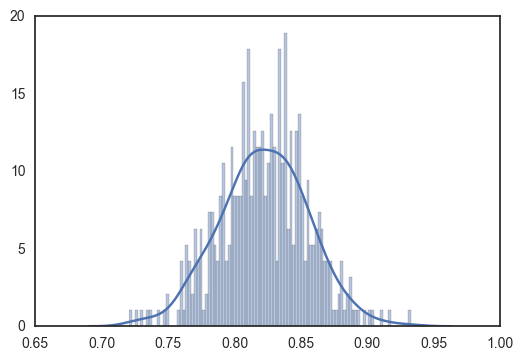

In [19]:
fs = [opt_res_convex_hull[col].fun for col in phi_convex_hull.columns]
sns.distplot(fs, bins=100)

In [21]:
for topic_name in phi_convex_hull.columns:
    if opt_res_convex_hull[topic_name].fun < 0.75:
        print_optimal_solution(opt_res_convex_hull[topic_name], _distances=distances_convex_hull, _saved_top_tokens=saved_top_tokens)

fun = 0.749994167557, optimized = True
topic_38 | topic_359 : 0.34 [0.83], topic_439 : 0.09 [0.87], topic_161 : 0.08 [0.89], topic_346 : 0.07 [0.89], topic_190 : 0.07 [0.87], topic_152 : 0.07 [0.91], topic_379 : 0.07 [0.88], topic_227 : 0.05 [0.89], topic_373 : 0.04 [0.89], topic_342 : 0.02 [0.90]
closest by distance to topic_38 | topic_38 : [0.00], topic_359 : [0.83], topic_439 : [0.87], topic_190 : [0.87], topic_379 : [0.88], topic_227 : [0.89], topic_373 : [0.89], topic_161 : [0.89], topic_346 : [0.89], topic_342 : [0.90]

topic_38: реликтовый_излучение излучение космология флуктуация шум эксперимент распределение масштаб большой_взрыв параметр стержень область теория_инфляция наблюдение момент
topic_359: тёмный_материя наблюдение тёмный_энергия галактика эпоха скопление_галактика линия скопление плотность красный_смещение космология результат анизотропия_реликтовый_излучение группа спектр
topic_439: детектор тёмный_материя эксперимент антенна скрытый_масса результат излучение энерг

In [ ]:
models_file.close()